*This notebook is part of  course materials for CS 345: Machine Learning Foundations and Practice at Colorado State University.
Original versions were created by Ben Sattelberg and Asa Ben-Hur.
The content is availabe [on GitHub](https://github.com/asabenhur/CS345).*

*The text is released under the [CC BY-SA license](https://creativecommons.org/licenses/by-sa/4.0/), and code is released under the [MIT license](https://opensource.org/licenses/MIT).*

<a href="https://colab.research.google.com/github//asabenhur/CS345/blob/master/fall24/notebooks/module07_03_mnist_pytorch.ipynb">
  <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [15]:
# torch imports 
import torch,torchvision
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.transforms import ToTensor
torch.manual_seed(42)

# numpy / matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

In [16]:
# if you have a GPU we should enable it
# mps is the pytorch device that supports GPU computations on MacOS

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
# although mps is available on some macs, it's slower in practice so we will
# just use a cpu
#device="cpu"
print(f"Using {device} device")

Using mps device


# Neural Networks on Image Data

### Sidenote:  enabling GPUs on google colab

Until now we ran our neural networks on a CPU.  If you are running this notebook on google colab, you are in luck - google colab will allow you to run your code on a GPU.  Enabling a GPU is very simple:  All you need to do is navigate to Edit→Notebook Settings and select GPU from the Hardware Accelerator drop-down menu (also available from the Runtime menu).
This [colab notebook](https://colab.research.google.com/notebooks/gpu.ipynb) has instructions for verifying that you are using a GPU and see the resulting speedup.


## The MNIST dataset

In the previous notebooks we used PyTorch to solve toy problems and built some understanding of how the networks are solving those problems.  In this notebook, we'll look at the real (but still relatively easy) problem of handwritten digit recognition.  We will be using the MNIST (modified National Institute of Standards and Technology) database which has images taken from a NIST database of handwritten digits and modified by Yann Lecun, Corinna Cortes, and Christopher J.C. Burges to be more easily used in machine learning.

While no longer useful for demonstrating state-of-the-art advancments in machine learning, as a dataset, it will live on for a long time as both a teaching tools (see this lecture) and also some degree as a testbed for ideas aimed at better explaining the behavior of machine learning algorithms.  There is a good [Wikipedia article](https://en.wikipedia.org/wiki/MNIST_database) describing the dataset, which has been used in thousands of machine learning publications.

The first thing we need to do is to load the dataset.  Fortunately, Keras does this work for us:

In [18]:
# load the mnist training set:
data = torchvision.datasets.MNIST('/Users/asa/datasets',
                                  train=True,
                                  transform = ToTensor(),
                                  download=True,
                                 )
# ToTensor transforms the data into PyTorch tensors and normalizes
# the pixel values to be between 0 and 1.

Let's get some information about the dataset:

In [19]:
data

Dataset MNIST
    Number of datapoints: 60000
    Root location: /Users/asa/datasets
    Split: Train
    StandardTransform
Transform: ToTensor()

In [6]:
len(data)

60000

In [20]:
x, y = data[0]

In [21]:
type(x), x.shape, type(y)

(torch.Tensor, torch.Size([1, 28, 28]), int)

This tells that we have 60,000 input images, each of which is 28x28 pixels.  The labels are, unsuprisingly for a database of digits, the numbers 0 through 9, corresponding to which digit the image represents.

Let's look at one of the images:

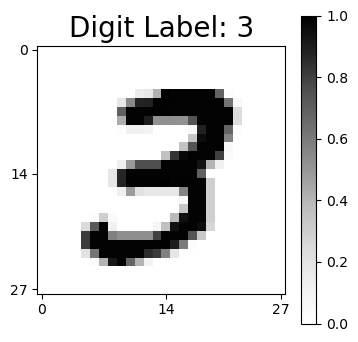

In [22]:
fig, ax = plt.subplots(1,1,figsize=(4,4))
pick = 7
im = ax.imshow(np.asarray(data[pick][0].squeeze()), cmap='Greys')
ax.set_title("Digit Label: " + str(data[pick][1]),fontsize=20)
cbar = fig.colorbar(im)
ax.set_xticks([0, 14, 27])
ax.set_yticks([0, 14, 27]);

Here we can see that the image is a grayscale 28x28 image with pixel values between 0 and 255.  We can also look at a few other images in the dataset:

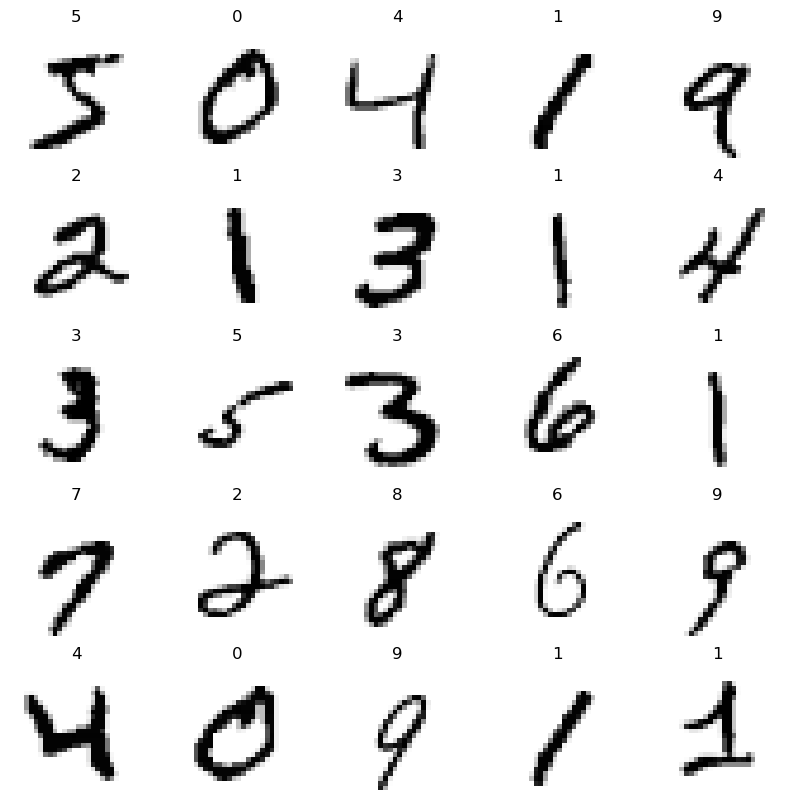

In [23]:
fig, axes = plt.subplots(5, 5, figsize=(10,10))

for i in range(5):
    for j in range(5):
        x,y = data[i*5 + j]
        axes[i,j].imshow(np.asarray(x).squeeze(), cmap='Greys')
        axes[i,j].set_title(y)
        axes[i,j].axis('off')

There are a few things we want to do to the input data before we use it.  The first is to convert it to 32 bit floats:

In [25]:
data_loader = torch.utils.data.DataLoader(data,
                                          batch_size=4,
                                          shuffle=True)

In [24]:
train_examples, train_labels = next(iter(data_loader))
print(f"Feature batch shape: {train_examples.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([4, 1, 28, 28])
Labels batch shape: torch.Size([4])


The first dimension indexes each image, while the third and fourth correspond to the image itself.  What about the second dimension?  This dimension corresponds to the number of "channels" in the image.  This data is grayscale, but color images are typically stored in RGB (red, green, blue) format, where there the three channels describe the amount of red, green, and blue at each pixel.  PyTorch is designed to handle images as a native data format without needing to "flatten" the images into vectors as a preprocessing step.

It's also useful to restrict the outputs of our network to look like probabilities.  One way to do this would be to normalize the outputs to be
\begin{align*}
z_1' &= \frac{z_1}{z_1 + z_2} \\
z_2' &= \frac{z_2}{z_1 + z_2}
\end{align*}
which gives us $z_1'$ and $z_2'$ values each between zero and one and summing to one.  One thing to keep in mind here is that although these now form a probability distribution, it isn't necessarily accurate to view $z_1'$ as the "probability that the input is of class one" because the approximation given by our network may not be a perfect statstical model of that fact.

Another way to do this would be to take the hard max of the outputs,
\begin{align*}
z_1' &= \begin{cases} 1 & z_1 \geq z_2 \\ 0 & z_1 < z_2 \end{cases} \\
z_2' &= \begin{cases} 0 & z_1 \geq z_2 \\ 1 & z_1 < z_2 \end{cases},
\end{align*}
which has similar nice properties but is unfortunately not differentiable, so we can't actually use it for classification.

A comprimise between these two is softmax.  For our two raw outputs, $z_1$ and $z_2$, the softmax activation function is calculated as

$$
\text{softmax}(z_1, z_2) = \left( \frac{e^{z_1}}{e^{z_1} + e^{z_2}}, 
   \frac{e^{z_2}}{e^{z_1} + e^{z_2}} \right)
$$

This is very similar to normalization, but with the exponential function of the raw inputs instead.  This means that values will be driven to behave more similarly to the hardmax while still maintaining differentiability.

### Visualizing the effect of the softmax function

Here is a simple bit of code to help you visualize what happens when the activations on the last layer of a classification network are run through the softmax function:

In [26]:
def apply_softmax(acts) :
    exp_acts = np.array([np.exp(x) for x in acts])
    exp_acts_sum = np.sum(exp_acts)
    acts_smax = np.array([np.exp(x)/exp_acts_sum for x in acts])
    return exp_acts, acts_smax

def visualize_softmax(mean, sigma, nsamples, rseed) :
    rng = np.random.default_rng(rseed)
    act = rng.normal(mean, sigma, nsamples)
    aex, asf = apply_softmax(act)
    #plt.style.use('seaborn-deep')
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(13,5))
    ax1.bar(range(nsamples), act, color='darkred')
    ax1.set_xlabel('Output Node')
    ax1.set_ylabel('Activation')
    ax1.set_title('Activations')   
    ax2.bar(range(nsamples), aex, color='darkblue')
    ax2.set_xlabel('Output Node')
    ax2.set_ylabel('After Exponentiation')
    ax2.set_title('Exponentiated Activation')  
    ax3.bar(range(nsamples), asf, color='darkgreen')
    ax3.set_xlabel('Output Node')
    ax3.set_ylabel('Activation')
    ax3.set_title('After Softmax')
    

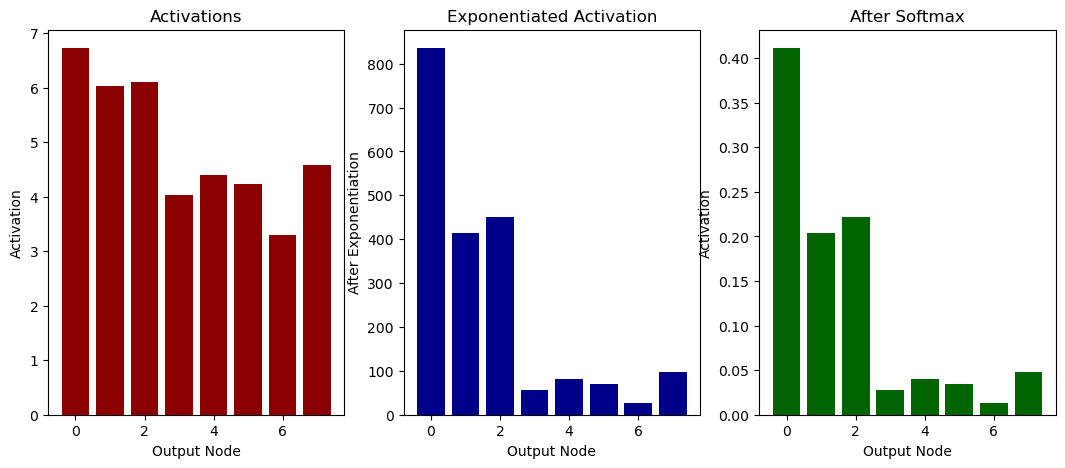

In [27]:
visualize_softmax(5, 1.0, 8, 82)

### A multi-layer perceptron


We can now train our model.  One layer to notice is the ```Flatten()``` layer.  This layer converts the data from a 1x28x28 dimensional image to a 784=28\*28 dimensional vector.

In [28]:
# based on the network from the PyTorch tutorial:
# https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html

class mnist_network(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        x = self.linear_relu_stack(x)
        return x

In [29]:
model = mnist_network().to(device)
print(model)

mnist_network(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


How many parameters does this model have?  First, let's think, how many parameters does a linear layer that maps $m$ features into $n$ features?

In [30]:
x=data[0][0].to(device)
logits = model(x)
pred_prob = nn.Softmax(dim=1)(logits)
y_pred = pred_prob.argmax(1)
print(f"Predicted class: {y_pred}")

Predicted class: tensor([8], device='mps:0')


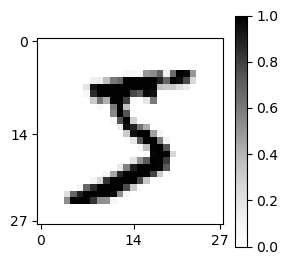

In [31]:
fig, ax = plt.subplots(1,1,figsize=(3,3))
x=data[0][0]
im = ax.imshow(np.asarray(x.squeeze()), cmap='Greys')
cbar = fig.colorbar(im)
ax.set_xticks([0, 14, 27])
ax.set_yticks([0, 14, 27]);

In [32]:
def train_epoch(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    total_loss = 0
    # set the model to training mode - important when you have 
    # batch normalization and dropout layers
    # unnecessary here
    model.train()
    for batch_idx, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        # Compute prediction and loss
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        # backpropagation
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        if batch_idx % 100 == 0:
            current = (batch_idx + 1) * len(X)
            print(f"loss: {loss.item():>7f}  [{current:>5d}/{size:>5d}]")
    return total_loss / num_batches

def validation(dataloader, model, loss_fn):
    # set the model to evaluation mode 
    # unnecessary here
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    # Evaluating the model with torch.no_grad() ensures that no gradients 
    # are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage 
    # for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            test_loss += loss_fn(y_pred, y).item()
            correct += (y_pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss, correct


In [33]:
test_data = torchvision.datasets.MNIST('/Users/asa/datasets',
                                  train=False,
                                  transform = ToTensor(),
                                  download=True,
                                 )

In [13]:
#%%timeit -r1 -n1
learning_rate = 1e-3
batch_size = 64
epochs = 10

train_dataloader = torch.utils.data.DataLoader(data, batch_size=batch_size,
                                               shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                               shuffle=True)

model = mnist_network().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

train_loss = []
validation_loss = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    loss = train_epoch(train_dataloader, model, loss_fn, optimizer)
    train_loss.append(loss)
    loss, accuracy = validation(valid_dataloader, model, loss_fn)
    validation_loss.append(loss)
print("Done!")

Epoch 1
-------------------------------
loss: 2.302086  [   64/60000]
loss: 2.297112  [ 6464/60000]
loss: 2.296503  [12864/60000]
loss: 2.293768  [19264/60000]
loss: 2.289661  [25664/60000]
loss: 2.281394  [32064/60000]
loss: 2.276015  [38464/60000]
loss: 2.273767  [44864/60000]
loss: 2.278811  [51264/60000]
loss: 2.267740  [57664/60000]
Test Error: 
 Accuracy: 44.3%, Avg loss: 2.261429 

Epoch 2
-------------------------------
loss: 2.264051  [   64/60000]
loss: 2.267910  [ 6464/60000]
loss: 2.248530  [12864/60000]
loss: 2.255048  [19264/60000]
loss: 2.232354  [25664/60000]
loss: 2.238160  [32064/60000]
loss: 2.223180  [38464/60000]
loss: 2.212997  [44864/60000]
loss: 2.209454  [51264/60000]
loss: 2.211365  [57664/60000]
Test Error: 
 Accuracy: 64.1%, Avg loss: 2.201889 

Epoch 3
-------------------------------
loss: 2.217616  [   64/60000]
loss: 2.205966  [ 6464/60000]
loss: 2.194484  [12864/60000]
loss: 2.190596  [19264/60000]
loss: 2.149126  [25664/60000]
loss: 2.166480  [32064/600

We can also look at the accuracy over the epochs of the network:

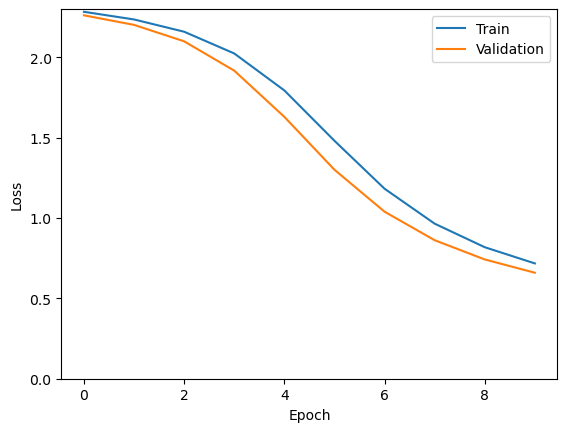

In [14]:
plt.plot(train_loss, label='Train')
plt.plot(validation_loss, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend();
plt.ylim([0, 2.3]);

MNIST is commonly used as a tutorial dataset, and one of the reasons for that is that basically anything will be successful on it.  The dataset is "solved" - some methods do better than human accuracy and will reach around 99.9% accuracy.

For reference, and to convince ourselves that we obtained good accuracy with our neural network let's try random forests:

In [28]:
X_train_list = [data[i][0].flatten().numpy() for i in range(len(data))]
X_train = np.row_stack(X_train_list)
y_train = np.array([data[i][1] for i in range(len(data))])
X_train.shape

(60000, 784)

In [29]:
X_test_list = [test_data[i][0].flatten().numpy() for i in range(len(test_data))]
X_test = np.row_stack(X_test_list)
y_test = np.array([test_data[i][1] for i in range(len(test_data))])
X_test.shape

(10000, 784)

In [30]:
run_rf = True
if run_rf :
    from sklearn.ensemble import RandomForestClassifier
    rf = RandomForestClassifier(n_estimators=500)
    rf.fit(X_train, y_train);
    from sklearn.metrics import accuracy_score
    y_pred = rf.predict(X_test)
    print(accuracy_score(y_pred, y_test))

0.971


### Comments

There are major issues in using feed-forward neural networks for image classification:

* Fully connected networks can have very large numbers of parameters with increasing image sizes.  Consider for example images of size 228x228x3, which is standard in this field.  Using the network architecture we have here would result in 228\*228\*3\*100 parameters from the input to the hidden layer - about 15,000,000.  This network would also not be successful - we would need to significantly increase the width and depth, compounding the issue.  It is likely that billions of parameters would be necessary to achieve good accuracy.
* If we take an image that represents the number seven, and shift the seven over a few pixels, we would expect it to still be classified as a seven.  However, fully connected networks are not able to represent this invariance.

Some of these concerns apply to other standard machine learning approaches as well.
Convolutional networks which are introduced next, address these shortcomings, and have led to major improvements in accuracy in image classification tasks.  Their success has led to a renaissance of the field of neural networks.